# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

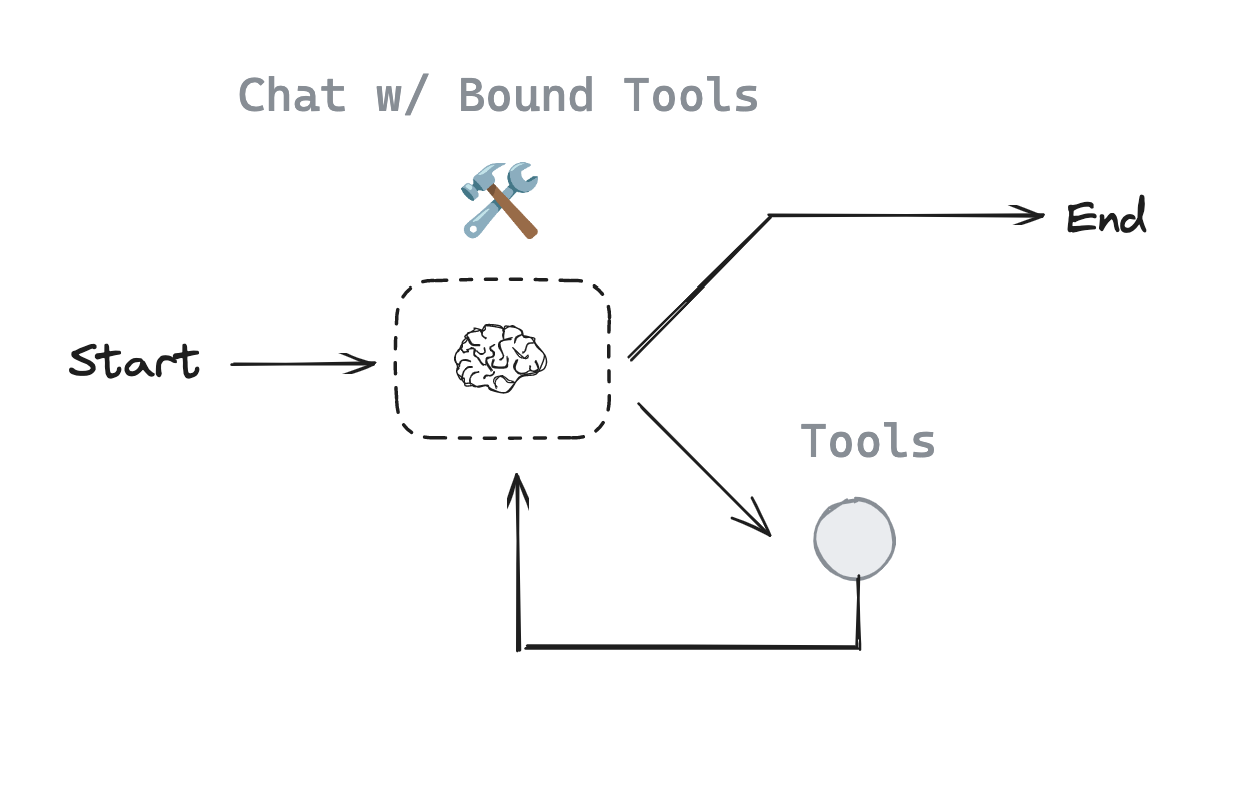

## Goals

Now, we're going extend our agent by introducing memory.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [1]:
import os
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

This follows what we did previously.

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [2]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

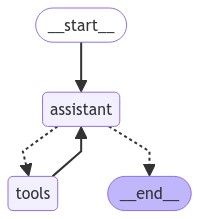

In [4]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [5]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_ztu1asTXzFNaoWSDzUwaTubI)
 Call ID: call_ztu1asTXzFNaoWSDzUwaTubI
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


Now, let's multiply by 2!

In [6]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YvpLdbd0VNhsPID82YjPbqG3)
 Call ID: call_YvpLdbd0VNhsPID82YjPbqG3
  Args:
    a: None
    b: 2
================================= Tool Message =================================
Name: multiply

Error: ValidationError(model='multiplySchema', errors=[{'loc': ('a',), 'msg': 'none is not an allowed value', 'type': 'type_error.none.not_allowed'}])
 Please fix your mistakes.
================================== Ai Message ==================================

It seems like I don't have the initial number to multiply by 2. Could you please provide the number you want to multiply?


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

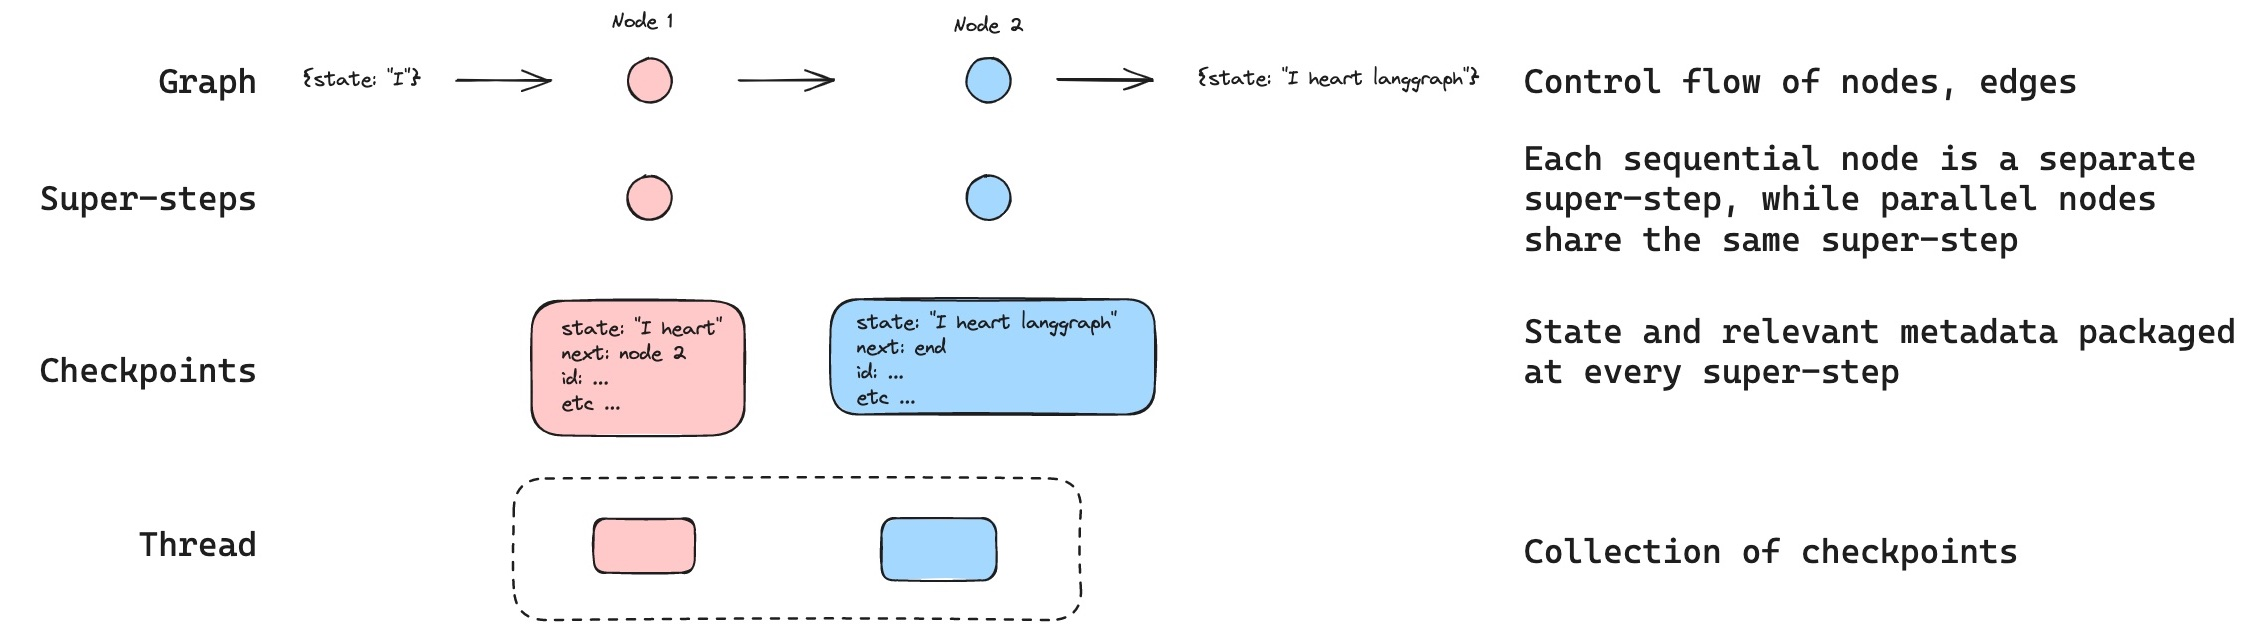


In [8]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_23tmdvhv1VAfMxIZnFBFHJD7)
 Call ID: call_23tmdvhv1VAfMxIZnFBFHJD7
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [9]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_23tmdvhv1VAfMxIZnFBFHJD7)
 Call ID: call_23tmdvhv1VAfMxIZnFBFHJD7
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_aFKM1qZxhnsW9YICm8xSeLpG)
 Call ID: call_aFKM1qZxhnsW9YICm8xSeLpG
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## LangGraph Studio

Load the `agent` in the UI, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.